# 1. Setup

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# from sklearn.metrics import f1_score
# from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style="whitegrid")

# 2. Data Preprocessing

In [182]:
SEED = 42

train_q = pd.read_excel("./data/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx")
train_c = pd.read_excel("./data/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx")
test_q = pd.read_excel("./data/TEST/TEST_QUANTITATIVE_METADATA.xlsx")
test_c = pd.read_excel("./data/TEST/TEST_CATEGORICAL_METADATA.xlsx")

train_combined = pd.merge(train_q, train_c, on='participant_id', how='left').set_index("participant_id")
test_combined = pd.merge(test_q, test_c, on='participant_id', how='left').set_index("participant_id")

labels = pd.read_excel("data/TRAIN/TRAINING_SOLUTIONS.xlsx").set_index("participant_id")

train_combined = train_combined.sort_index()
labels = labels.sort_index()
assert all(train_combined.index == labels.index), "Label IDs do not match train IDs"

In [183]:
train_combined.head()

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,...,MRI_Track_Age_at_Scan,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
participant_id,,,,,,,,,,,,,,,,,,,,,
00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,...,14.274127,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,...,NaN,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,...,13.463381,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,...,9.572553,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,...,6.654574,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN


In [184]:
train_combined.columns

Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

This is some explanation of feature present in the dataset

## Numerical features: Total of 18 features
+ EHQ_EHQ_Total: laterality index score (float) || -100 = 10th left, −28 ≤ LI < 48 = middle, 100 = 10th right"
+ ColorVision_CV_Score: color vision test score (int)
+ MRI_Track_Age_at_Scan: Age at time of MRI scan (float)

### ALABAMA PARENTING QUESTIONAIRE - PARENT REPORT (INT)
+ APQ_P_APQ_P_CP: Reflects the frequency or severity of corporal punishment used by parents
+ APQ_P_APQ_P_ID: Measures inconsistency in parental discipline
+ APQ_P_APQ_P_INV: Indicates the level of parental involvement in the child’s life
+ APQ_P_APQ_P_OPD: Other Discipline Practices Score (Not factored into total score but provides item level information)
+ APQ_P_APQ_P_PM: Reflects how well a parent monitors and supervises their child
+ APQ_P_APQ_P_PP: Captures the extent of positive reinforcement and supportive parenting

### Strength and Difficulties Questionnaire (INT)
+ SDQ_SDQ_Conduct_Problems: Measures behavioral issues related to rule-breaking or aggression (higher score = more prone to ADHD)
+ SDQ_SDQ_Difficulties_Total: A composite measure summarizing overall difficulties across several behavioral domains
+ SDQ_SDQ_Emotional_Problems: Focuses on internal emotional difficulties such as anxiety or depression (social related)
+ SDQ_SDQ_Externalizing: Captures outward-directed behaviors such as hyperactivity, impulsivity, and conduct issues
+ SDQ_SDQ_Generating_Impact: This might reflect the overall impact of the child’s behavioral problems on their social and academic life
+ SDQ_SDQ_Hyperactivity: Directly measures the hyperactive and impulsive behaviors central to many ADHD diagnoses (HIGHLY CORRELATED FEATURE)
+ SDQ_SDQ_Internalizing: Reflects inward-focused behaviors such as social withdrawal and anxiety
+ SDQ_SDQ_Peer_Problems: Assesses difficulties in interacting with peers
+ SDQ_SDQ_Prosocial: Evaluates positive social behaviors like empathy and cooperation

## Features Informative For Predicting Sex (Based on domain knowledge only) (17 FEATURES)
+ EHQ_EHQ_Total (VERY IMPORTANT)
+ ColorVision_CV_Score (VERY IMPORTANT)

!! (APQ_ features) Differences in discipline or supervision could interact with gender expectations and thus be indirectly predictive of sex.
+ APQ_P_APQ_P_CP
+ APQ_P_APQ_P_ID
+ APQ_P_APQ_P_INV
+ APQ_P_APQ_P_OPD
+ APQ_P_APQ_P_PM
+ APQ_P_APQ_P_PP
+ SDQ_SDQ_Conduct_Problems
+ SDQ_SDQ_Difficulties_Total
+ SDQ_SDQ_Emotional_Problems
+ SDQ_SDQ_Externalizing
+ SDQ_SDQ_Generating_Impact
+ SDQ_SDQ_Hyperactivity
+ SDQ_SDQ_Internalizing
+ SDQ_SDQ_Peer_Problems
+ SDQ_SDQ_Prosocial

ALL APQ_ AND SDQ_ FEATURES ARE SOMEWHAT IMPORTANT

## Features Informative For Predicting ADHD (Based on domain knowledge only) (18 FEATURES)
+ EHQ_EHQ_Total (SOMEWHAT IMPORTANT)
+ ColorVision_CV_Score
+ MRI_Track_Age_at_Scan (VERY IMPORTANT)
+ APQ_P_APQ_P_CP
+ APQ_P_APQ_P_ID (SOMEWHAT IMPORTANT)
+ APQ_P_APQ_P_INV (VERY IMPORTANT)
+ APQ_P_APQ_P_OPD
+ APQ_P_APQ_P_PM (SOMEWHAT IMPORTANT)
+ APQ_P_APQ_P_PP (VERY IMPORTANT)
+ SDQ_SDQ_Conduct_Problems (SOMEWHAT IMPORTANT)
+ SDQ_SDQ_Difficulties_Total (SOMEWHAT IMPORTANT)
+ SDQ_SDQ_Emotional_Problems
+ SDQ_SDQ_Externalizing (VERY IMPORTANT)
+ SDQ_SDQ_Generating_Impact
+ SDQ_SDQ_Hyperactivity (VERY IMPORTANT)
+ SDQ_SDQ_Internalizing (VERY IMPORTANT)
+ SDQ_SDQ_Peer_Problems
+ SDQ_SDQ_Prosocial

## 2.1 Numerical Features Visualization

In [185]:
numerical_features = [
    'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
    'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
    'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
    'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
    'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
    'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
    'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan'
]

print(len(numerical_features))

18


In [186]:
numerical_features_df = train_combined[numerical_features]

def nan_summary(df, name):
    print(f"---- {name} NAN SUMMARY ----")
    print((df.isnull().sum() / len(df) * 100).sort_values(ascending=False), '\n')

nan_summary(numerical_features_df, "TRAIN NUMERICAL FEATURES")

---- TRAIN NUMERICAL FEATURES NAN SUMMARY ----
MRI_Track_Age_at_Scan         29.678483
ColorVision_CV_Score           1.896125
EHQ_EHQ_Total                  1.071723
APQ_P_APQ_P_CP                 0.989283
APQ_P_APQ_P_INV                0.989283
APQ_P_APQ_P_ID                 0.989283
APQ_P_APQ_P_PM                 0.989283
APQ_P_APQ_P_PP                 0.989283
APQ_P_APQ_P_OPD                0.989283
SDQ_SDQ_Conduct_Problems       0.741962
SDQ_SDQ_Difficulties_Total     0.741962
SDQ_SDQ_Emotional_Problems     0.741962
SDQ_SDQ_Generating_Impact      0.741962
SDQ_SDQ_Externalizing          0.741962
SDQ_SDQ_Hyperactivity          0.741962
SDQ_SDQ_Internalizing          0.741962
SDQ_SDQ_Peer_Problems          0.741962
SDQ_SDQ_Prosocial              0.741962
dtype: float64 



### 2.1.1 EHQ_EHQ_Total

In [187]:
median_val = train_combined["EHQ_EHQ_Total"].median()
train_combined["EHQ_EHQ_Total"].fillna(median_val, inplace=True)
print("Missing values after fill:", train_combined["EHQ_EHQ_Total"].isna().sum())

median_test_val = test_combined["EHQ_EHQ_Total"].median()
test_combined["EHQ_EHQ_Total"].fillna(median_test_val, inplace=True)
print("Missing values after fill:", test_combined["EHQ_EHQ_Total"].isna().sum())

Missing values after fill: 0
Missing values after fill: 0


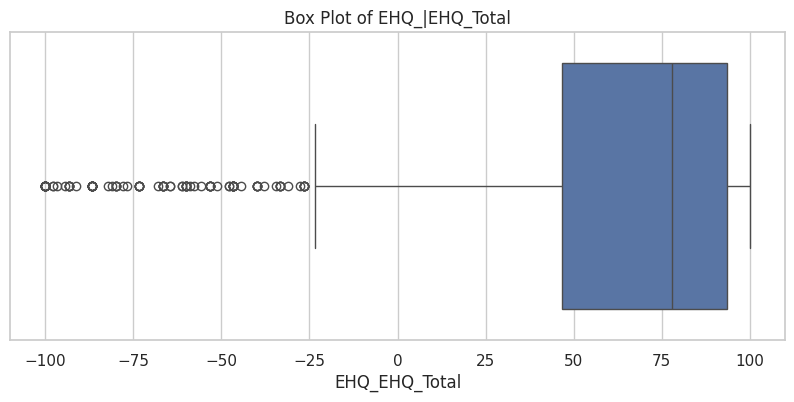

In [188]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=train_combined, x='EHQ_EHQ_Total')
plt.title("Box Plot of EHQ_|EHQ_Total")
plt.xlabel("EHQ_EHQ_Total")
plt.show()

In [189]:
def categorize_laterality(li):
    if -110 <= li <= -28:
        return "Left-Lateralized"
    elif -28 < li <= 47:
        return 'Middle'
    elif 47 < li <= 110:
        return 'Right-Lateralized'

train_combined['Laterality_Category'] = train_combined['EHQ_EHQ_Total'].apply(categorize_laterality)
test_combined['Laterality_Category'] = test_combined['EHQ_EHQ_Total'].apply(categorize_laterality)

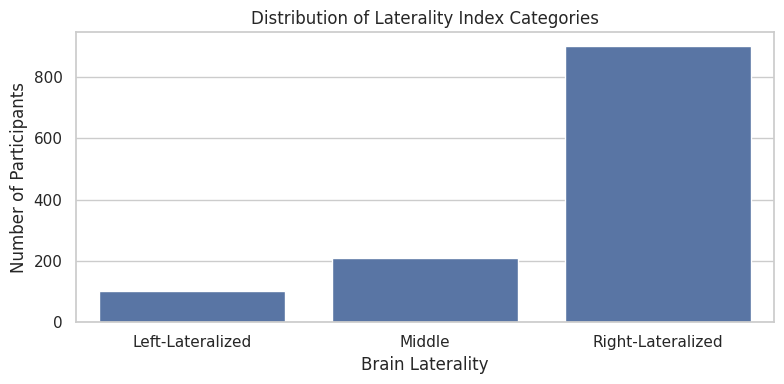

In [190]:
plt.figure(figsize=(8, 4))
sns.countplot(data=train_combined, x="Laterality_Category", order=["Left-Lateralized", "Middle", "Right-Lateralized"])
plt.title("Distribution of Laterality Index Categories")
plt.xlabel("Brain Laterality")
plt.ylabel("Number of Participants")
plt.tight_layout()
plt.show()

### 2.1.2 ColorVision_CV_Score

In [191]:
train_combined['ColorVision_CV_Score'].fillna(14, inplace=True)
print("Missing values after fill:", train_combined["ColorVision_CV_Score"].isna().sum())

test_combined['ColorVision_CV_Score'].fillna(14, inplace=True)
print("Missing values after fill:", test_combined["ColorVision_CV_Score"].isna().sum())

Missing values after fill: 0
Missing values after fill: 0


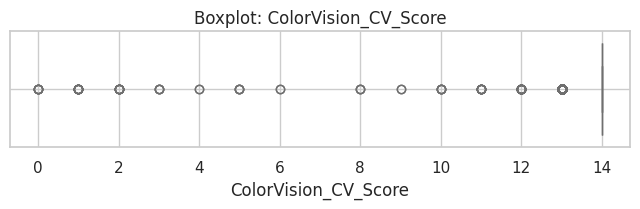

In [192]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined['ColorVision_CV_Score'], color="skyblue")
plt.title('Boxplot: ColorVision_CV_Score')
plt.xlabel('ColorVision_CV_Score')
plt.grid(True)
plt.show()

In [193]:
train_combined['ColorVision_CV_Score'] = train_combined['ColorVision_CV_Score'].astype('category')
test_combined['ColorVision_CV_Score'] = test_combined['ColorVision_CV_Score'].astype('category')

In [194]:
def categorize_vision(score):
    if score <= 13:
        return 'not_strong'
    else:
        return 'strong'

train_combined['ColorVision_Level'] = train_combined['ColorVision_CV_Score'].astype(float).apply(categorize_vision)
test_combined['ColorVision_Level'] = test_combined['ColorVision_CV_Score'].astype(float).apply(categorize_vision)

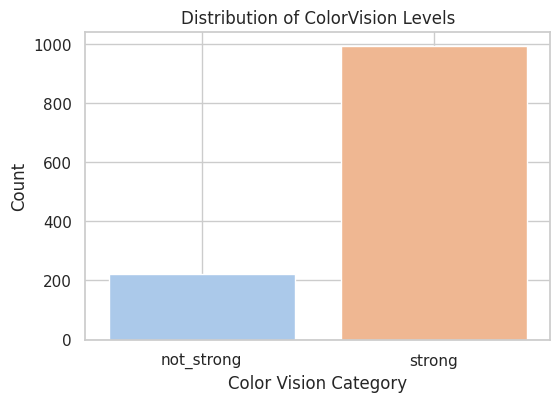

In [195]:
plt.figure(figsize=(6, 4))
sns.countplot(data=train_combined, x='ColorVision_Level', order=['not_strong', 'strong'], palette='pastel')
plt.title('Distribution of ColorVision Levels')
plt.xlabel('Color Vision Category')
plt.ylabel('Count')
plt.grid(True)
plt.show()

### 2.1.3 APQ_P_APQ_P_CP

In [196]:
nan_count = train_combined['APQ_P_APQ_P_CP'].isna().sum()
print(f"Number of NaN values in APQ_P_APQ_P_CP: {nan_count}")

median_cp = train_combined['APQ_P_APQ_P_CP'].median()
train_combined['APQ_P_APQ_P_CP'] = train_combined['APQ_P_APQ_P_CP'].fillna(median_cp)
print(f"Filled NaNs with median: {median_cp}")

median_test_cp = test_combined['APQ_P_APQ_P_CP'].median()
test_combined['APQ_P_APQ_P_CP'] = test_combined['APQ_P_APQ_P_CP'].fillna(median_test_cp)
print(f"Filled NaNs with median: {median_test_cp}")

Number of NaN values in APQ_P_APQ_P_CP: 12
Filled NaNs with median: 3.0
Filled NaNs with median: 3.0


Number of outliers in APQ_P_APQ_P_CP: 127
Outlier values: [6, 7, 8, 9, 10, 12]


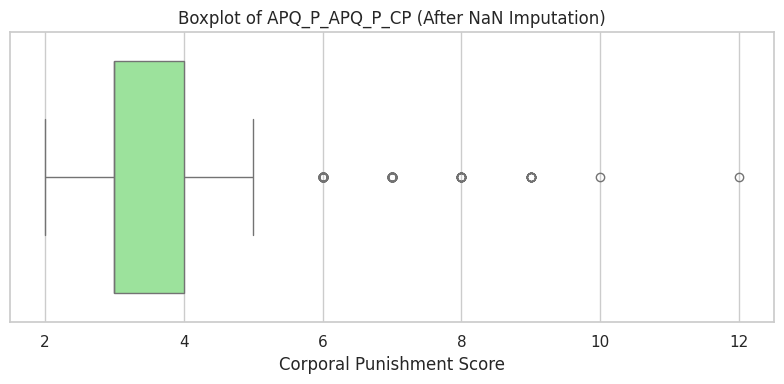

In [197]:
cp_scores = train_combined['APQ_P_APQ_P_CP']
Q1 = cp_scores.quantile(0.25)
Q3 = cp_scores.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = cp_scores[(cp_scores < lower_bound) | (cp_scores > upper_bound)]
print(f"Number of outliers in APQ_P_APQ_P_CP: {len(outliers)}")

outlier_values = list(set([int(i) for i in outliers.values]))
print(f"Outlier values: {outlier_values}")

plt.figure(figsize=(8, 4))
sns.boxplot(x=train_combined['APQ_P_APQ_P_CP'], orient='h', color='lightgreen')
plt.title('Boxplot of APQ_P_APQ_P_CP (After NaN Imputation)')
plt.xlabel('Corporal Punishment Score')
plt.tight_layout()
plt.show()

In [198]:
train_combined['APQ_CP_is_high'] = (train_combined['APQ_P_APQ_P_CP'] > 5).astype(int)
test_combined['APQ_CP_is_high'] = (test_combined['APQ_P_APQ_P_CP'] > 5).astype(int)

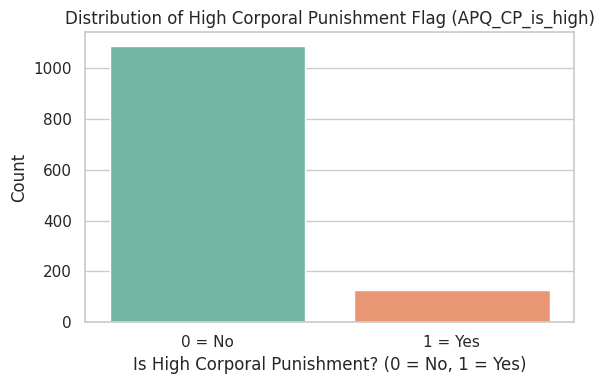

In [199]:
plt.figure(figsize=(6, 4))
sns.countplot(x=train_combined['APQ_CP_is_high'], palette="Set2")
plt.title('Distribution of High Corporal Punishment Flag (APQ_CP_is_high)')
plt.xlabel('Is High Corporal Punishment? (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.xticks([0, 1], ['0 = No', '1 = Yes'])
plt.tight_layout()
plt.show()

### 2.1.4: APQ_P_APQ_P_ID

In [200]:
feature = 'APQ_P_APQ_P_ID'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in {feature}: {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature].fillna(median_value, inplace=True)
print(f"Filled NaNs in {feature} with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature].fillna(median_test_value, inplace=True)
print(f"Filled NaNs in {feature} with median value: {median_test_value}")

Number of NaN rows in APQ_P_APQ_P_ID: 12
Filled NaNs in APQ_P_APQ_P_ID with median value: 13.0
Filled NaNs in APQ_P_APQ_P_ID with median value: 13.0


Number of outliers in APQ_P_APQ_P_ID: 3


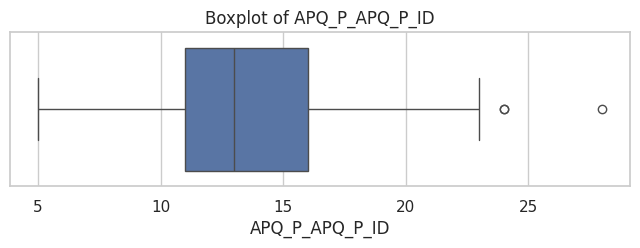

In [201]:
Q1 = train_combined[feature].quantile(0.25)
Q3 = train_combined[feature].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
print(f"Number of outliers in {feature}: {len(outliers)}")

plt.figure(figsize=(8, 2))
sns.boxplot(x=train_combined[feature], orient='h')
plt.title(f'Boxplot of {feature}')
plt.show()

### 2.1.5: APQ_P_APQ_P_INV

In [202]:
feature = 'APQ_P_APQ_P_INV'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaNs in '{feature}' with median: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaNs in '{feature}' with median: {median_test_value}")

Number of NaN rows in feature 'APQ_P_APQ_P_INV': 12
Filled NaNs in 'APQ_P_APQ_P_INV' with median: 40.0
Filled NaNs in 'APQ_P_APQ_P_INV' with median: 40.0


Number of outliers in 'APQ_P_APQ_P_INV': 3
Outlier threshold: lower < 25.50, upper > 53.50


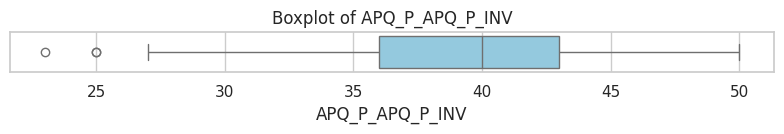

In [203]:
Q1 = train_combined[feature].quantile(0.25)
Q3 = train_combined[feature].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
print(f"Number of outliers in '{feature}': {len(outliers)}")
print(f"Outlier threshold: lower < {lower_bound:.2f}, upper > {upper_bound:.2f}")

plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined[feature], color="skyblue")
plt.title(f'Boxplot of {feature}')
plt.xlabel(feature)
plt.tight_layout()
plt.show()

### 2.1.6: APQ_P_APQ_P_OPD

In [204]:
feature = 'APQ_P_APQ_P_OPD'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaNs in '{feature}' with median: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaNs in '{feature}' with median: {median_test_value}")

Number of NaN rows in feature 'APQ_P_APQ_P_OPD': 12
Filled NaNs in 'APQ_P_APQ_P_OPD' with median: 18.0
Filled NaNs in 'APQ_P_APQ_P_OPD' with median: 17.0


Number of outliers in 'APQ_P_APQ_P_OPD': 13
Outlier threshold: lower < 10.00, upper > 26.00


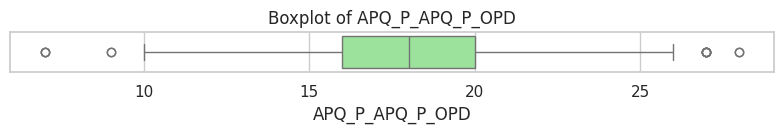

In [205]:
Q1 = train_combined[feature].quantile(0.25)
Q3 = train_combined[feature].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
print(f"Number of outliers in '{feature}': {len(outliers)}")
print(f"Outlier threshold: lower < {lower_bound:.2f}, upper > {upper_bound:.2f}")

plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined[feature], color="lightgreen")
plt.title(f'Boxplot of {feature}')
plt.xlabel(feature)
plt.tight_layout()
plt.show()

### 2.1.7: APQ_P_APQ_P_PM

In [206]:
feature = 'APQ_P_APQ_P_PM'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaNs in '{feature}' with median: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaNs in '{feature}' with median: {median_test_value}")

Number of NaN rows in feature 'APQ_P_APQ_P_PM': 12
Filled NaNs in 'APQ_P_APQ_P_PM' with median: 16.0
Filled NaNs in 'APQ_P_APQ_P_PM' with median: 15.0


Number of outliers in 'APQ_P_APQ_P_PM': 37
Outlier threshold: lower < 4.00, upper > 28.00


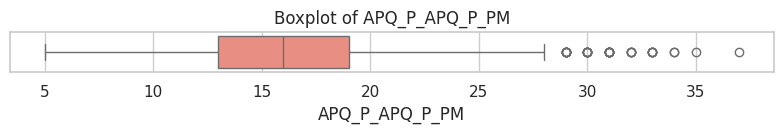

In [207]:
Q1 = train_combined[feature].quantile(0.25)
Q3 = train_combined[feature].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
print(f"Number of outliers in '{feature}': {len(outliers)}")
print(f"Outlier threshold: lower < {lower_bound:.2f}, upper > {upper_bound:.2f}")

plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined[feature], color="salmon")
plt.title(f'Boxplot of {feature}')
plt.xlabel(feature)
plt.tight_layout()
plt.show()

### 2.1.8 APQ_P_APQ_P_PP

In [208]:
feature = 'APQ_P_APQ_P_PP'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaNs in '{feature}' with median: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaNs in '{feature}' with median: {median_test_value}")

Number of NaN rows in feature 'APQ_P_APQ_P_PP': 12
Filled NaNs in 'APQ_P_APQ_P_PP' with median: 26.0
Filled NaNs in 'APQ_P_APQ_P_PP' with median: 25.0


Number of outliers in 'APQ_P_APQ_P_PP': 2
Outlier threshold: lower < 15.50, upper > 35.50


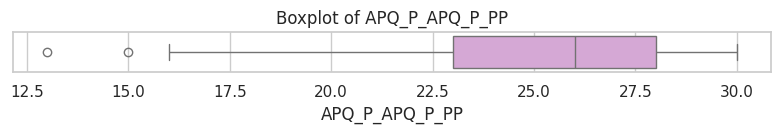

In [209]:
Q1 = train_combined[feature].quantile(0.25)
Q3 = train_combined[feature].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
print(f"Number of outliers in '{feature}': {len(outliers)}")
print(f"Outlier threshold: lower < {lower_bound:.2f}, upper > {upper_bound:.2f}")

plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined[feature], color="plum")
plt.title(f'Boxplot of {feature}')
plt.xlabel(feature)
plt.tight_layout()
plt.show()

### 2.1.9 SDQ_SDQ_Conduct_Problems

In [210]:
feature = 'SDQ_SDQ_Conduct_Problems'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaNs in '{feature}' with median: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaNs in '{feature}' with median: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Conduct_Problems': 9
Filled NaNs in 'SDQ_SDQ_Conduct_Problems' with median: 2.0
Filled NaNs in 'SDQ_SDQ_Conduct_Problems' with median: 1.0


Number of outliers in 'SDQ_SDQ_Conduct_Problems': 17
Outlier threshold: lower < -4.50, upper > 7.50


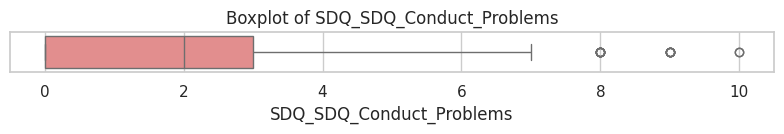

In [211]:
Q1 = train_combined[feature].quantile(0.25)
Q3 = train_combined[feature].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
print(f"Number of outliers in '{feature}': {len(outliers)}")
print(f"Outlier threshold: lower < {lower_bound:.2f}, upper > {upper_bound:.2f}")

plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined[feature], color="lightcoral")
plt.title(f'Boxplot of {feature}')
plt.xlabel(feature)
plt.tight_layout()
plt.show()

### 2.1.10 SDQ_SDQ_Difficulties_Total

In [212]:
feature = 'SDQ_SDQ_Difficulties_Total'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Difficulties_Total': 9
Filled NaN with median value: 12.0
Filled NaN with median value: 11.0


Number of outliers in 'SDQ_SDQ_Difficulties_Total': 1


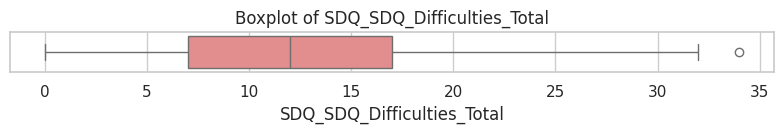

In [213]:
Q1 = train_combined[feature].quantile(0.25)
Q3 = train_combined[feature].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
print(f"Number of outliers in '{feature}': {len(outliers)}")

plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined[feature], color="lightcoral")
plt.title(f'Boxplot of {feature}')
plt.xlabel(feature)
plt.tight_layout()
plt.show()

### 2.1.11: SDQ_SDQ_Emotional_Problems

In [214]:
feature = 'SDQ_SDQ_Emotional_Problems'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Emotional_Problems': 9
Filled NaN with median value: 2.0
Filled NaN with median value: 2.0


Number of outliers in 'SDQ_SDQ_Emotional_Problems': 11


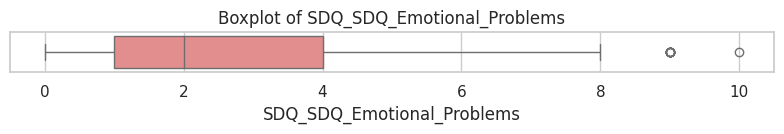

In [215]:
Q1 = train_combined[feature].quantile(0.25)
Q3 = train_combined[feature].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
print(f"Number of outliers in '{feature}': {len(outliers)}")

plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined[feature], color="lightcoral")
plt.title(f'Boxplot of {feature}')
plt.xlabel(feature)
plt.tight_layout()
plt.show()

### 2.1.12: SDQ_SDQ_Externalizing

In [216]:
feature = 'SDQ_SDQ_Externalizing'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Externalizing': 9
Filled NaN with median value: 8.0
Filled NaN with median value: 7.0


Number of outliers in 'SDQ_SDQ_Externalizing': 7


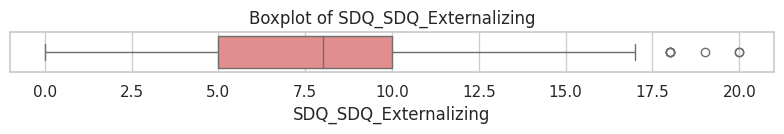

In [217]:
Q1 = train_combined[feature].quantile(0.25)
Q3 = train_combined[feature].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
print(f"Number of outliers in '{feature}': {len(outliers)}")

plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined[feature], color="lightcoral")
plt.title(f'Boxplot of {feature}')
plt.xlabel(feature)
plt.tight_layout()
plt.show()

### 2.1.13: SDQ_SDQ_Generating_Impact

In [218]:
feature = 'SDQ_SDQ_Generating_Impact'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Generating_Impact': 9
Filled NaN with median value: 4.0
Filled NaN with median value: 4.0


Number of outliers in 'SDQ_SDQ_Generating_Impact': 0


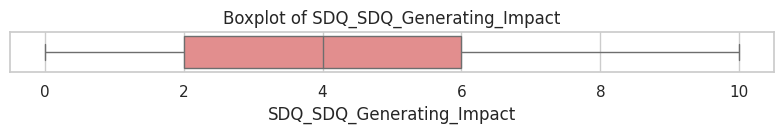

In [219]:
Q1 = train_combined[feature].quantile(0.25)
Q3 = train_combined[feature].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
print(f"Number of outliers in '{feature}': {len(outliers)}")

plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined[feature], color="lightcoral")
plt.title(f'Boxplot of {feature}')
plt.xlabel(feature)
plt.tight_layout()
plt.show()

### 2.1.14: SDQ_SDQ_Hyperactivity

In [220]:
feature = 'SDQ_SDQ_Hyperactivity'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Hyperactivity': 9
Filled NaN with median value: 6.0
Filled NaN with median value: 6.0


Number of outliers in 'SDQ_SDQ_Hyperactivity': 0


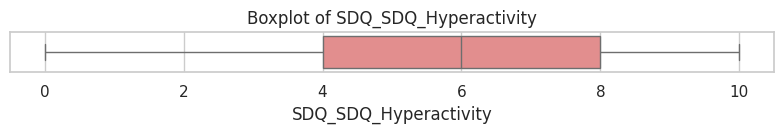

In [221]:
Q1 = train_combined[feature].quantile(0.25)
Q3 = train_combined[feature].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
print(f"Number of outliers in '{feature}': {len(outliers)}")

plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined[feature], color="lightcoral")
plt.title(f'Boxplot of {feature}')
plt.xlabel(feature)
plt.tight_layout()
plt.show()

### 2.1.15: SDQ_SDQ_Internalizing

In [222]:
feature = 'SDQ_SDQ_Internalizing'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Internalizing': 9
Filled NaN with median value: 4.0
Filled NaN with median value: 4.0


Number of outliers in 'SDQ_SDQ_Internalizing': 10


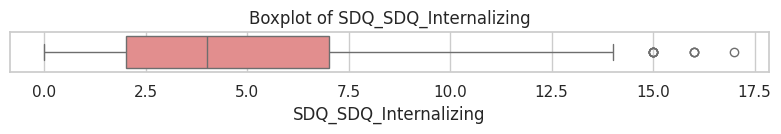

In [223]:
Q1 = train_combined[feature].quantile(0.25)
Q3 = train_combined[feature].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
print(f"Number of outliers in '{feature}': {len(outliers)}")

plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined[feature], color="lightcoral")
plt.title(f'Boxplot of {feature}')
plt.xlabel(feature)
plt.tight_layout()
plt.show()

### 2.1.16: SDQ_SDQ_Peer_Problems

In [224]:
feature = 'SDQ_SDQ_Peer_Problems'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Peer_Problems': 9
Filled NaN with median value: 2.0
Filled NaN with median value: 1.0


Number of outliers in 'SDQ_SDQ_Peer_Problems': 0


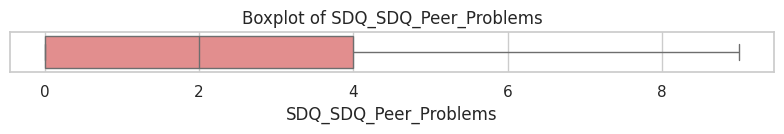

In [225]:
Q1 = train_combined[feature].quantile(0.25)
Q3 = train_combined[feature].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
print(f"Number of outliers in '{feature}': {len(outliers)}")

plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined[feature], color="lightcoral")
plt.title(f'Boxplot of {feature}')
plt.xlabel(feature)
plt.tight_layout()
plt.show()

### 2.1.17: SDQ_SDQ_Prosocial

In [226]:
feature = 'SDQ_SDQ_Prosocial'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Prosocial': 9
Filled NaN with median value: 8.0
Filled NaN with median value: 8.0


Number of outliers in 'SDQ_SDQ_Prosocial': 0


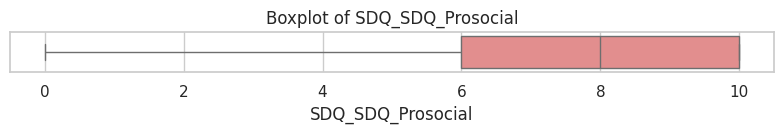

In [227]:
Q1 = train_combined[feature].quantile(0.25)
Q3 = train_combined[feature].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
print(f"Number of outliers in '{feature}': {len(outliers)}")

plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined[feature], color="lightcoral")
plt.title(f'Boxplot of {feature}')
plt.xlabel(feature)
plt.tight_layout()
plt.show()

### 2.1.18: MRI_Track_Age_at_Scan

In [228]:
feature = 'MRI_Track_Age_at_Scan'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

Number of NaN rows in feature 'MRI_Track_Age_at_Scan': 360


In [229]:
numeric_data = train_combined[numerical_features].copy()
imputer = IterativeImputer(estimator=LassoCV(random_state=SEED), max_iter=100, random_state=SEED)

numeric_data_imputed = pd.DataFrame(
    imputer.fit_transform(numeric_data), 
    columns=numerical_features, 
    index=numeric_data.index
)

# Update MRI_Track_Age_at_Scan in train
train_combined['MRI_Track_Age_at_Scan'] = numeric_data_imputed['MRI_Track_Age_at_Scan']

In [230]:
# Prepare test numeric data with same columns
test_numeric_data = test_combined[numerical_features].copy()

# Transform only MRI_Track_Age_at_Scan using imputer from train
test_numeric_data_imputed = pd.DataFrame(
    imputer.transform(test_numeric_data),
    columns=numerical_features,
    index=test_numeric_data.index
)

# Update only this feature
test_combined['MRI_Track_Age_at_Scan'] = test_numeric_data_imputed['MRI_Track_Age_at_Scan']

Number of outliers in 'MRI_Track_Age_at_Scan': 16


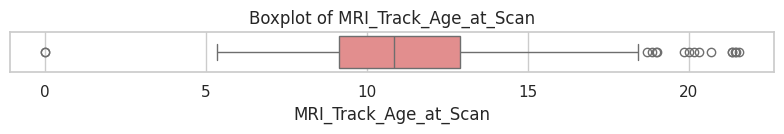

In [231]:
Q1 = train_combined[feature].quantile(0.25)
Q3 = train_combined[feature].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
print(f"Number of outliers in '{feature}': {len(outliers)}")

plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined[feature], color="lightcoral")
plt.title(f'Boxplot of {feature}')
plt.xlabel(feature)
plt.tight_layout()
plt.show()

In [232]:
train_combined.drop(columns=['EHQ_EHQ_Total', 'ColorVision_CV_Score'], inplace=True)
test_combined.drop(columns=['EHQ_EHQ_Total', 'ColorVision_CV_Score'], inplace=True)

## 2.2 Categorical Features Visualization

TOTAL OF 12 FEATURE

### Explanations based on domain knowledge
+ Basic_Demos_Enroll_Year: the year when the participant enrolled in the study (int) (NOT VERY IMPORTANT)
+ Basic_Demos_Study_Site: Location/site where the subject was assessed (NOT VERY IMPORTANT)
+ PreInt_Demos_Fam_Child_Ethnicity: Ethnic background of the child
+ PreInt_Demos_Fam_Child_Race: Race of the child
+ MRI_Track_Scan_Location: Where the MRI was performed
+ Barratt_Barratt_P1_Edu: education of the parent 1 (ORDINAL)
+ Barratt_Barratt_P1_Occ: occupation of parent 1 (ORDINAL)
+ Barratt_Barratt_P2_Edu: education of the parent 2 (ORDINAL)
+ Barratt_Barratt_P2_Occ: occupation of parent 2 (ORDINAL)
+ Laterality_Category: Categorical brain lateralization: left, middle, or right
+ ColorVision_Level: Categorical encoding of color vision test (BINARY)
+ APQ_CP_is_high: Is Corporal Punishment score high (>6) (BINARY)

### Features Important in Predicting Sex 
+ PreInt_Demos_Fam_Child_Ethnicity (SOMEWHAT IMPORTANT)
+ PreInt_Demos_Fam_Child_Race (SOMEWHAT IMPORTANT)
+ Barratt_Barratt_P1_Edu (SOMEWHAT IMPORTANT)
+ Barratt_Barratt_P1_Occ (SOMEWHAT IMPORTANT)
+ Barratt_Barratt_P2_Edu (SOMEWHAT IMPORTANT)
+ Barratt_Barratt_P2_Occ (SOMEWHAT IMPORTANT)
+ Laterality_Category (SUPER IMPORTANT)
+ ColorVision_Level (SUPER IMPORTANT)
+ APQ_CP_is_high (SOMEWHAT IMPORTANT)

### Features Important in Predicting ADHD
+ PreInt_Demos_Fam_Child_Ethnicity (SUPER IMPORTANT)
+ PreInt_Demos_Fam_Child_Race (SUPER IMPORTANT)
+ Barratt_Barratt_P1_Edu (SUPER IMPORTANT)
+ Barratt_Barratt_P1_Occ (SUPER IMPORTANT)
+ Barratt_Barratt_P2_Edu (SOMEWHAT IMPORTANT)
+ Barratt_Barratt_P2_Occ (SOMEWHAT IMPORTANT)
+ Laterality_Category (SUPER IMPORTANT)
+ ColorVision_Level (SOMEWHAT IMPORTANT)
+ APQ_CP_is_high (SUPER IMPORTANT)

In [233]:
categorical_features = [
    'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
    'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
    'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
    'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
    'Barratt_Barratt_P2_Occ', 'Laterality_Category', 'ColorVision_Level',
    'APQ_CP_is_high'
]

print(len(categorical_features))   

12


### 2.2.1 Basic_Demos_Enroll_Year

In [234]:
feature = 'Basic_Demos_Enroll_Year'
nan_count_train = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count_train}")
nan_count_test = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_count_test}")

Number of NaN rows in feature 'Basic_Demos_Enroll_Year': 0
Number of NaN rows in test feature 'Basic_Demos_Enroll_Year': 0


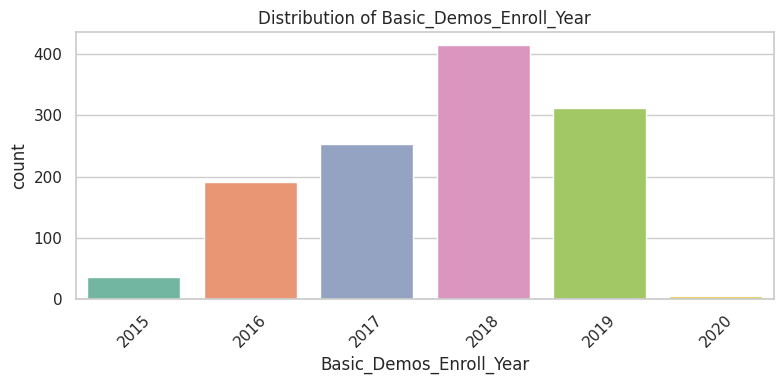

In [235]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette="Set2")
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Rare categories in 'Basic_Demos_Enroll_Year' (fewer than 50 instances):
Basic_Demos_Enroll_Year
2015    36
2020     5
Name: count, dtype: int64


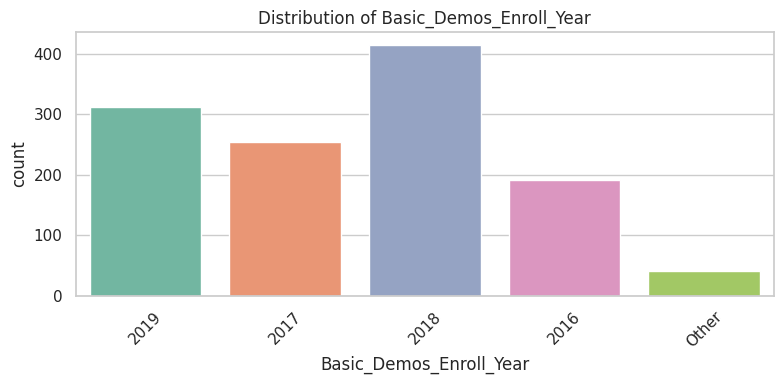

In [236]:
category_counts = train_combined[feature].value_counts()
rare_categories = category_counts[category_counts < 50]

print(f"Rare categories in '{feature}' (fewer than 50 instances):")
print(rare_categories)

threshold = 50

category_counts = train_combined[feature].value_counts()
rare_categories = category_counts[category_counts < threshold].index

train_combined[feature] = train_combined[feature].apply(
    lambda x: 'Other' if x in rare_categories else str(x)
)

plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette="Set2")
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.2.2: Basic_Demos_Study_Site

In [237]:
feature = 'Basic_Demos_Study_Site'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

nan_count_test = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_count_test}")

Number of NaN rows in feature 'Basic_Demos_Study_Site': 0
Number of NaN rows in test feature 'Basic_Demos_Study_Site': 0


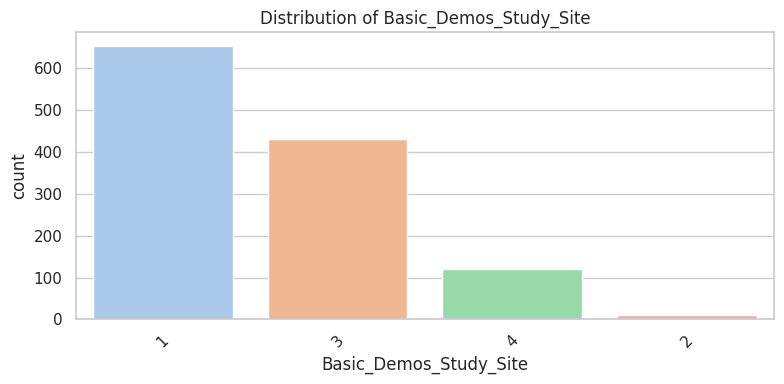

In [238]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Rare categories in 'Basic_Demos_Study_Site' (fewer than 10 instances):
Basic_Demos_Study_Site
2    11
Name: count, dtype: int64


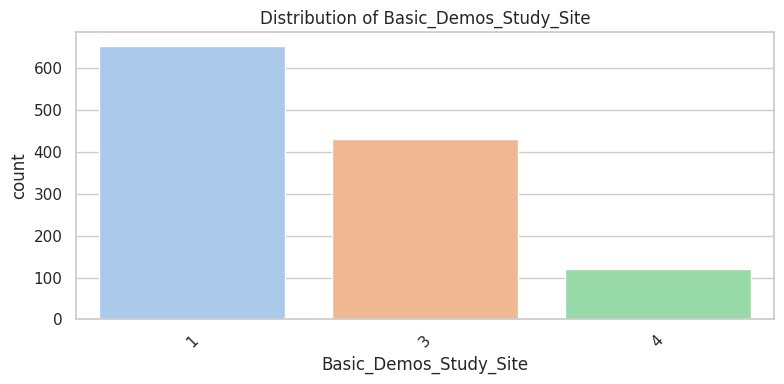

In [239]:
category_counts = train_combined[feature].value_counts()
rare_categories = category_counts[category_counts < 25] # 50

print(f"Rare categories in '{feature}' (fewer than 10 instances):")
print(rare_categories)

# drop value 2
train_combined = train_combined[train_combined[feature] != 2]
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.2.3: PreInt_Demos_Fam_Child_Ethnicity

In [240]:
feature = 'PreInt_Demos_Fam_Child_Ethnicity'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

nan_count_test = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_count_test}")

Number of NaN rows in feature 'PreInt_Demos_Fam_Child_Ethnicity': 42
Number of NaN rows in test feature 'PreInt_Demos_Fam_Child_Ethnicity': 3


In [241]:
train_combined[feature] = train_combined[feature].fillna(3.0)
test_combined[feature] = test_combined[feature].fillna(3.0)

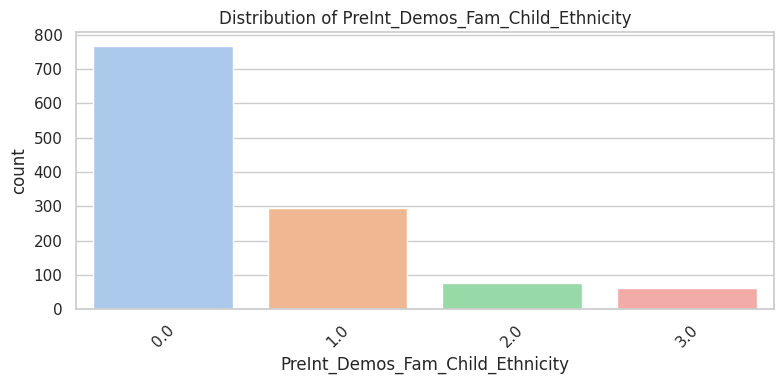

In [242]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

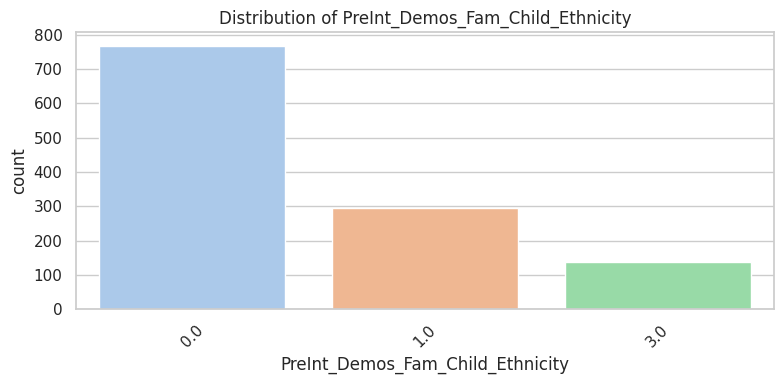

In [243]:
# combine values 2 and 3
train_combined[feature] = train_combined[feature].replace({2: 3})

plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.2.4: PreInt_Demos_Fam_Child_Race

In [244]:
feature = 'PreInt_Demos_Fam_Child_Race'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

nan_test_count = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_test_count}")

Number of NaN rows in feature 'PreInt_Demos_Fam_Child_Race': 53
Number of NaN rows in test feature 'PreInt_Demos_Fam_Child_Race': 6


In [245]:
train_combined[feature] = train_combined[feature].fillna(10.0)
test_combined[feature] = test_combined[feature].fillna(10.0)

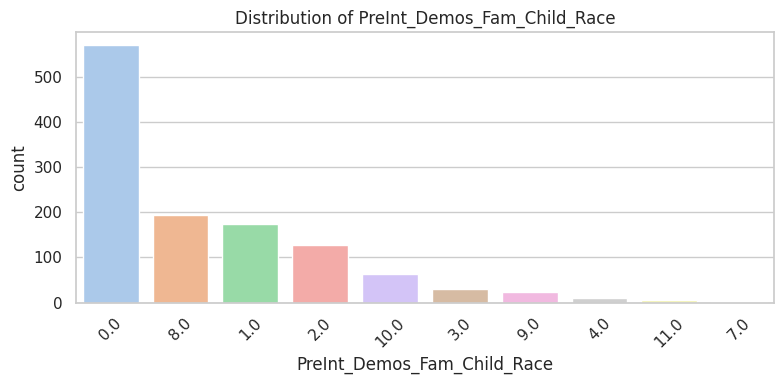

In [246]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

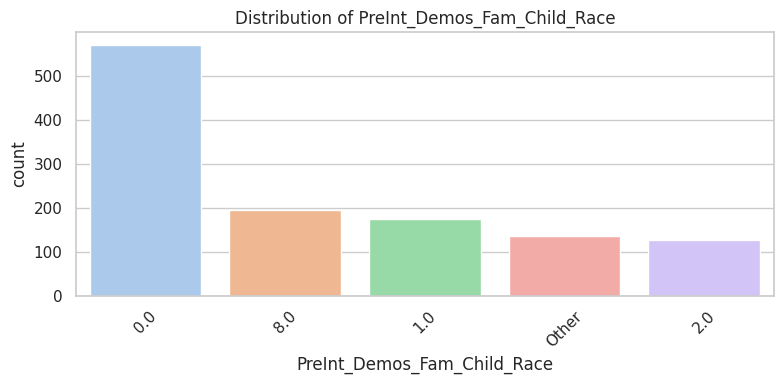

In [247]:
# Đếm số lượng của các category
category_counts = train_combined[feature].value_counts()

# Lọc ra các category có số lượng dưới 50
rare_categories = category_counts[category_counts < 100].index

# Gộp các category này thành "Other"
train_combined[feature] = train_combined[feature].replace(rare_categories, 'Other')

# Vẽ lại biểu đồ phân phối
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', 
              order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2.2.5: MRI_Track_Scan_Location

In [248]:
feature = 'MRI_Track_Scan_Location'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

nan_test_count = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_test_count}")

Number of NaN rows in feature 'MRI_Track_Scan_Location': 3
Number of NaN rows in test feature 'MRI_Track_Scan_Location': 0


In [249]:
train_combined[feature] = train_combined[feature].fillna(4.0)
test_combined[feature] = test_combined[feature].fillna(4.0)

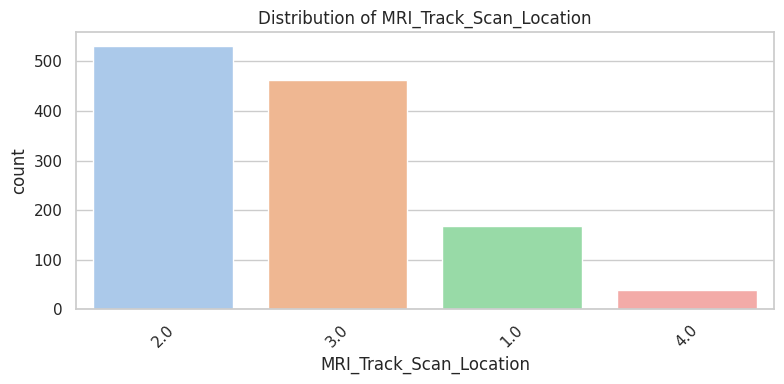

In [250]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

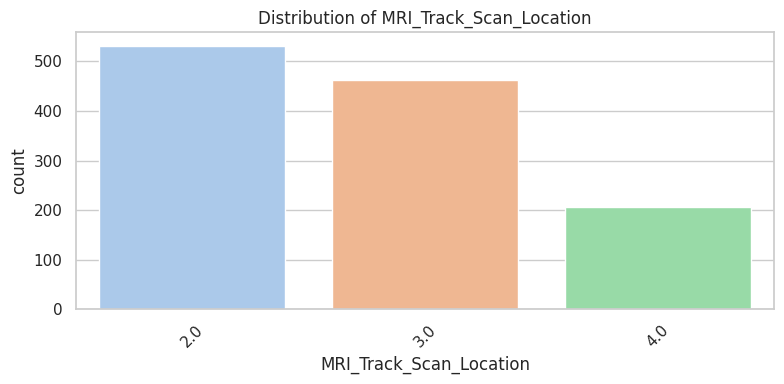

In [251]:
# combine values 1 and 4
train_combined[feature] = train_combined[feature].replace({1: 4})
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2.2.6: Barratt_Barratt_P1_Edu

In [252]:
feature = 'Barratt_Barratt_P1_Edu'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

nan_test_count = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_test_count}")

Number of NaN rows in feature 'Barratt_Barratt_P1_Edu': 15
Number of NaN rows in test feature 'Barratt_Barratt_P1_Edu': 1


In [253]:
train_combined[feature] = train_combined[feature].fillna(18.0)
test_combined[feature] = test_combined[feature].fillna(18.0)

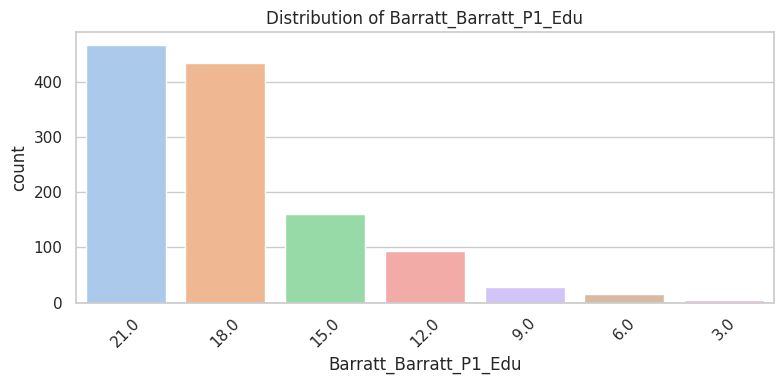

In [254]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

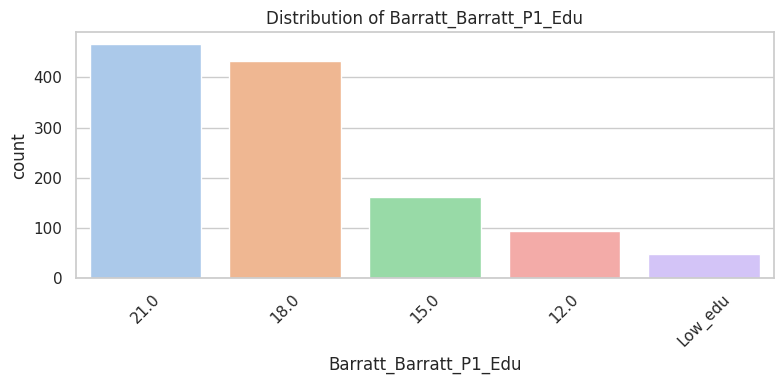

In [255]:
# Đếm số lượng của các category
category_counts = train_combined[feature].value_counts()

# Lọc ra các category có số lượng dưới 50
rare_categories = category_counts[category_counts < 50].index

# Gộp các category này thành "Other"
train_combined[feature] = train_combined[feature].replace(rare_categories, 'Low_edu')

# Vẽ lại biểu đồ phân phối
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', 
              order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2.2.7: Barratt_Barratt_P1_Occ

In [256]:
feature = 'Barratt_Barratt_P1_Occ'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

nan_test_count = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_test_count}")

Number of NaN rows in feature 'Barratt_Barratt_P1_Occ': 31
Number of NaN rows in test feature 'Barratt_Barratt_P1_Occ': 1


In [257]:
median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN in '{feature}' with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN in '{feature}' with median value: {median_test_value}")

Filled NaN in 'Barratt_Barratt_P1_Occ' with median value: 30.0
Filled NaN in 'Barratt_Barratt_P1_Occ' with median value: 35.0


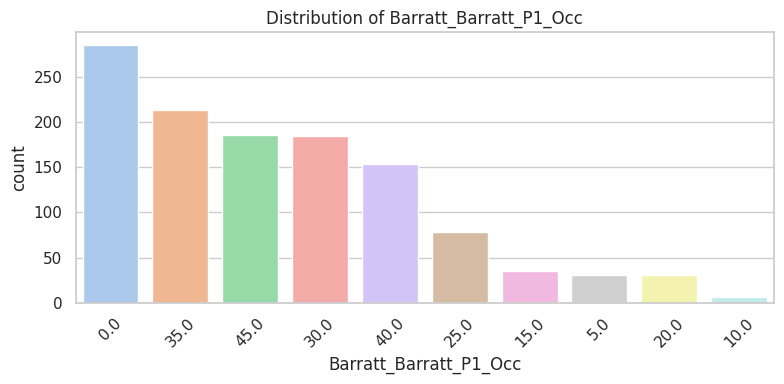

In [258]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

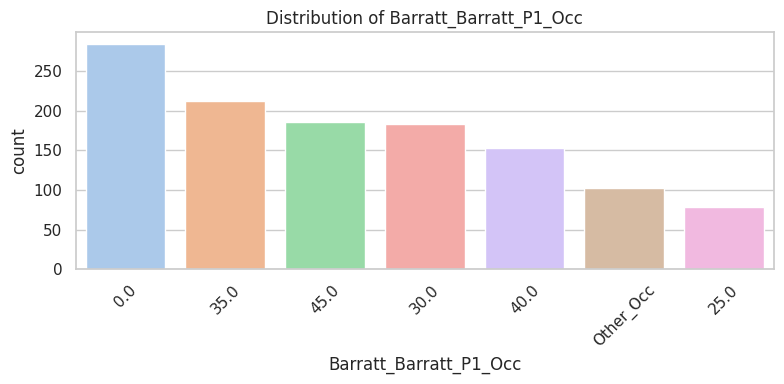

In [259]:
# Tính toán tỉ lệ phần trăm của mỗi category
category_counts = train_combined[feature].value_counts(normalize=True)

# Lọc ra các category có tỉ lệ > 5% (0.05)
popular_categories = category_counts[category_counts > 0.05].index

# Thay thế các category không phổ biến thành "Other_Occ"
train_combined[feature] = train_combined[feature].apply(lambda x: x if x in popular_categories else 'Other_Occ')

# Vẽ lại biểu đồ phân phối
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', 
              order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2.2.8: Barratt_Barratt_P2_Edu

In [260]:
feature = 'Barratt_Barratt_P2_Edu'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

nan_test_count = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_test_count}")

Number of NaN rows in feature 'Barratt_Barratt_P2_Edu': 197
Number of NaN rows in test feature 'Barratt_Barratt_P2_Edu': 36


In [261]:
def impute_p2_edu(row):
    if pd.isna(row['Barratt_Barratt_P2_Edu']):
        return row['Barratt_Barratt_P1_Edu']
    return row['Barratt_Barratt_P2_Edu']

train_combined['Barratt_Barratt_P2_Edu'] = train_combined.apply(impute_p2_edu, axis=1)
test_combined['Barratt_Barratt_P2_Edu'] = test_combined.apply(impute_p2_edu, axis=1)

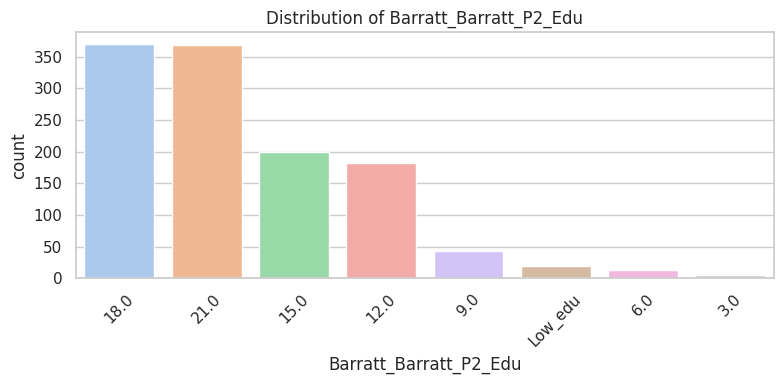

In [262]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

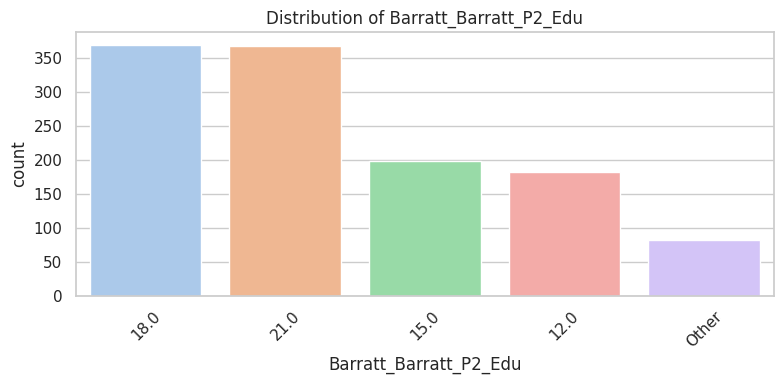

In [263]:
# Tính toán tỉ lệ phần trăm của mỗi category
category_counts = train_combined[feature].value_counts(normalize=True)

# Lọc ra các category có tỉ lệ > 5% (0.05)
popular_categories = category_counts[category_counts > 0.05].index

# Thay thế các category không phổ biến thành "Other_Occ"
train_combined[feature] = train_combined[feature].apply(lambda x: x if x in popular_categories else 'Other')

# Vẽ lại biểu đồ phân phối
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', 
              order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2.2.9: Barratt_Barratt_P2_Occ

In [264]:
feature = 'Barratt_Barratt_P2_Occ'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

nan_test_count = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_test_count}")

Number of NaN rows in feature 'Barratt_Barratt_P2_Occ': 220
Number of NaN rows in test feature 'Barratt_Barratt_P2_Occ': 42


In [265]:
def impute_p2_edu(row):
    if pd.isna(row['Barratt_Barratt_P2_Occ']):
        return row['Barratt_Barratt_P1_Occ']
    return row['Barratt_Barratt_P2_Occ']

train_combined['Barratt_Barratt_P2_Occ'] = train_combined.apply(impute_p2_edu, axis=1)
test_combined['Barratt_Barratt_P2_Occ'] = test_combined.apply(impute_p2_edu, axis=1)

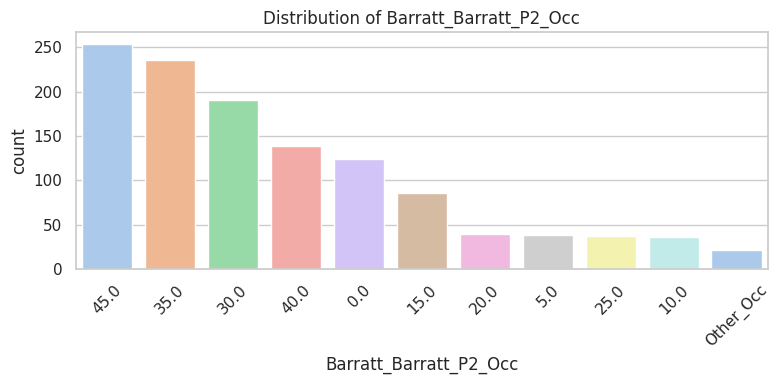

In [266]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [267]:
train_combined.drop(columns=['MRI_Track_Scan_Location', 'Basic_Demos_Study_Site'], inplace=True)
test_combined.drop(columns=['MRI_Track_Scan_Location', 'Basic_Demos_Study_Site'], inplace=True)

### 2.2.10 Laterality_Category and ColorVision_Level

In [268]:
from sklearn.preprocessing import LabelEncoder

le_laterality = LabelEncoder()
le_colorvision = LabelEncoder()

train_combined['Laterality_Category'] = le_laterality.fit_transform(train_combined['Laterality_Category'])
train_combined['ColorVision_Level'] = le_colorvision.fit_transform(train_combined['ColorVision_Level'])


# Step 2: Transform test set using same encoders
test_combined['Laterality_Category'] = le_laterality.transform(test_combined['Laterality_Category'])
test_combined['ColorVision_Level'] = le_colorvision.transform(test_combined['ColorVision_Level'])

In [269]:
laterality_mapping = dict(zip(le_laterality.classes_, le_laterality.transform(le_laterality.classes_)))
colorvision_mapping = dict(zip(le_colorvision.classes_, le_colorvision.transform(le_colorvision.classes_)))

print("Laterality_Category mapping:", laterality_mapping)
print("ColorVision_Level mapping:", colorvision_mapping)

Laterality_Category mapping: {'Left-Lateralized': np.int64(0), 'Middle': np.int64(1), 'Right-Lateralized': np.int64(2)}
ColorVision_Level mapping: {'not_strong': np.int64(0), 'strong': np.int64(1)}


# 3. Final

In [270]:
train_combined

,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,...,Basic_Demos_Enroll_Year,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Laterality_Category,ColorVision_Level,APQ_CP_is_high
participant_id,,,,,,,,,,,,,,,,,,,,,
00aIpNTbG5uh,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,...,2019,1.0,0.0,21.0,45.0,21.0,45.0,2,0,0
00fV0OyyoLfw,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,...,2017,0.0,Other,21.0,0.0,21.0,45.0,2,1,0
04X1eiS79T4B,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,...,2017,1.0,2.0,Low_edu,0.0,Other,0.0,2,1,0
05ocQutkURd6,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,...,2018,3.0,8.0,18.0,Other_Occ,18.0,0.0,2,1,0
06YUNBA9ZRLq,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,...,2018,0.0,1.0,12.0,0.0,12.0,0.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zpU7rEseBMH8,3.0,11.0,41.0,16.0,23.0,24.0,0.0,8.0,0.0,6.0,...,2017,0.0,Other,12.0,Other_Occ,21.0,45.0,2,1,0
zpr8w4jCfVPe,3.0,9.0,41.0,22.0,10.0,29.0,1.0,15.0,3.0,8.0,...,2019,1.0,2.0,12.0,Other_Occ,21.0,35.0,2,1,0
zwBG0rZ05Mcb,3.0,12.0,30.0,18.0,14.0,24.0,0.0,10.0,3.0,5.0,...,2016,0.0,0.0,15.0,35.0,18.0,35.0,1,0,0


In [271]:
test_combined

,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,...,Basic_Demos_Enroll_Year,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Laterality_Category,ColorVision_Level,APQ_CP_is_high
participant_id,,,,,,,,,,,,,,,,,,,,,
Cfwaf5FX7jWK,5.0,16.0,41.0,19.0,11.0,26.0,2.0,12.0,3.0,9.0,...,2022,0.0,0.0,21.0,30.0,18.0,30.0,2,1,0
vhGrzmvA3Hjq,3.0,13.0,43.0,18.0,15.0,28.0,2.0,16.0,8.0,5.0,...,2023,0.0,0.0,21.0,45.0,21.0,30.0,2,0,0
ULliyEXjy4OV,3.0,14.0,36.0,16.0,14.0,25.0,1.0,7.0,1.0,6.0,...,2022,0.0,0.0,21.0,40.0,18.0,40.0,1,0,0
LZfeAb1xMtql,3.0,19.0,41.0,17.0,18.0,27.0,4.0,15.0,4.0,10.0,...,2022,0.0,0.0,21.0,45.0,21.0,45.0,2,0,0
EnFOUv0YK1RG,3.0,13.0,42.0,19.0,16.0,28.0,2.0,18.0,6.0,12.0,...,2022,2.0,0.0,18.0,0.0,21.0,45.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UadZfjdEg7eG,3.0,17.0,41.0,17.0,11.0,25.0,1.0,18.0,7.0,7.0,...,2023,0.0,0.0,18.0,0.0,18.0,35.0,2,1,0
IUEHiLmQAqCi,5.0,12.0,38.0,22.0,9.0,29.0,2.0,16.0,2.0,11.0,...,2023,0.0,1.0,18.0,35.0,21.0,40.0,2,1,0
cRySmCadYFRO,3.0,14.0,42.0,15.0,10.0,28.0,1.0,11.0,4.0,4.0,...,2023,0.0,8.0,21.0,25.0,15.0,25.0,2,0,0


In [272]:
for feature in train_combined.columns:
    num_missing = train_combined[feature].isna().sum()
    print(f"{feature}: {num_missing} missing values")

APQ_P_APQ_P_CP: 0 missing values
APQ_P_APQ_P_ID: 0 missing values
APQ_P_APQ_P_INV: 0 missing values
APQ_P_APQ_P_OPD: 0 missing values
APQ_P_APQ_P_PM: 0 missing values
APQ_P_APQ_P_PP: 0 missing values
SDQ_SDQ_Conduct_Problems: 0 missing values
SDQ_SDQ_Difficulties_Total: 0 missing values
SDQ_SDQ_Emotional_Problems: 0 missing values
SDQ_SDQ_Externalizing: 0 missing values
SDQ_SDQ_Generating_Impact: 0 missing values
SDQ_SDQ_Hyperactivity: 0 missing values
SDQ_SDQ_Internalizing: 0 missing values
SDQ_SDQ_Peer_Problems: 0 missing values
SDQ_SDQ_Prosocial: 0 missing values
MRI_Track_Age_at_Scan: 0 missing values
Basic_Demos_Enroll_Year: 0 missing values
PreInt_Demos_Fam_Child_Ethnicity: 0 missing values
PreInt_Demos_Fam_Child_Race: 0 missing values
Barratt_Barratt_P1_Edu: 0 missing values
Barratt_Barratt_P1_Occ: 0 missing values
Barratt_Barratt_P2_Edu: 0 missing values
Barratt_Barratt_P2_Occ: 0 missing values
Laterality_Category: 0 missing values
ColorVision_Level: 0 missing values
APQ_CP_is_

In [273]:
for feature in test_combined.columns:
    num_missing = test_combined[feature].isna().sum()
    print(f"{feature}: {num_missing} missing values")

APQ_P_APQ_P_CP: 0 missing values
APQ_P_APQ_P_ID: 0 missing values
APQ_P_APQ_P_INV: 0 missing values
APQ_P_APQ_P_OPD: 0 missing values
APQ_P_APQ_P_PM: 0 missing values
APQ_P_APQ_P_PP: 0 missing values
SDQ_SDQ_Conduct_Problems: 0 missing values
SDQ_SDQ_Difficulties_Total: 0 missing values
SDQ_SDQ_Emotional_Problems: 0 missing values
SDQ_SDQ_Externalizing: 0 missing values
SDQ_SDQ_Generating_Impact: 0 missing values
SDQ_SDQ_Hyperactivity: 0 missing values
SDQ_SDQ_Internalizing: 0 missing values
SDQ_SDQ_Peer_Problems: 0 missing values
SDQ_SDQ_Prosocial: 0 missing values
MRI_Track_Age_at_Scan: 0 missing values
Basic_Demos_Enroll_Year: 0 missing values
PreInt_Demos_Fam_Child_Ethnicity: 0 missing values
PreInt_Demos_Fam_Child_Race: 0 missing values
Barratt_Barratt_P1_Edu: 0 missing values
Barratt_Barratt_P1_Occ: 0 missing values
Barratt_Barratt_P2_Edu: 0 missing values
Barratt_Barratt_P2_Occ: 0 missing values
Laterality_Category: 0 missing values
ColorVision_Level: 0 missing values
APQ_CP_is_

In [274]:
train_combined.to_csv('data/PREPROCESSING/train_processed.csv', index=False)
test_combined.to_csv('data/PREPROCESSING/test_processed.csv', index=False)

print("Complete!")

Complete!
